Bienvenidos a la segunda parte de mi proyecto Food Analytics, en este apartado realizaremos un modelo de clasificacion de imagenes utilizando dos modelos conocidos aplicando *transfer learning*


Comenzaremos obteniendo los datos, los cuales nos proporcionaron desde la academia INOVE.

In [ ]:
# Descargar el dataset
import gdown
import os
if os.access('10_food_classes_all_data', os.F_OK) is False:
    if os.access('10_food_classes_all_data.zip', os.F_OK) is False:
        url = 'https://drive.google.com/uc?id=1ltCRzJhGcmJITYq7o8XyrSAezXPYPzBX'
        output = '10_food_classes_all_data.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q 10_food_classes_all_data.zip
else:
    print("El archivo ya se encuentra descargado")

Downloading...
From (original): https://drive.google.com/uc?id=1ltCRzJhGcmJITYq7o8XyrSAezXPYPzBX
From (redirected): https://drive.google.com/uc?id=1ltCRzJhGcmJITYq7o8XyrSAezXPYPzBX&confirm=t&uuid=c7a13267-9436-4059-9b8f-8ae8b13498f1
To: /content/10_food_classes_all_data.zip
100%|██████████| 515M/515M [00:05<00:00, 90.5MB/s]


Mediante ImageDataGenerator crearemos un generador de imagenes por baches y tambien le aplicaremos un reescalado y reestructuracion.

In [ ]:
#Obtenemos las rutas de las imagenes de entrenamiento y validacion
train_dir = "10_food_classes_all_data/train/"
valid_dir = "10_food_classes_all_data/test/"

In [ ]:
#importamos ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Realizamos un reescalado
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Marcamos la ruta de las imagenes, el tipo de formato que las queremos, los lotes y el tipo de etiquetas
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               batch_size=20,
                                               class_mode='categorical')

Found 7500 images belonging to 10 classes.


In [ ]:
valid_data = valid_datagen.flow_from_directory(directory=valid_dir,
                                               target_size=(224, 224),
                                               batch_size=20,
                                               class_mode='categorical')

Found 2500 images belonging to 10 classes.


Comenzaremos con la creacion del modelo

In [ ]:
#Importamos VGG16 y ResNet50
from tensorflow.keras.applications import VGG16, ResNet50

In [ ]:
#Cargaremos los modelos sin las capaz

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
#Congelamos el modelo
vgg16.trainable = False
resnet50.trainable = False

In [ ]:
#Importamos las librerias que utilizaremos
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
#Aplicamos una reduccion de dimensionalidad para reducir el sobre ajuste
x = vgg16.output
x = GlobalAveragePooling2D()(x)  # Reducir la dimensionalidad del tensor
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # Salida para 10 clases
# Crear el modelo final
model_vgg = Model(inputs=vgg16.input, outputs=predictions)

In [ ]:
#Realizamos el mismo procedimiento con resnet
x = resnet50.output
x = GlobalAveragePooling2D()(x)  # Reducir la dimensionalidad del tensor
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # Salida para 10 clases

# Creamos el modelo final
model_resnet50 = Model(inputs=resnet50.input, outputs=predictions)

In [ ]:
#Observamos como se compone el modelo
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
#Copilamos los modelos
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Una vez copilados los modelos pasaremos a la parte del entrenamiento y la visualizacion de los resultados.

In [ ]:
#Instanciamos las variables steps per epoch
train_steps = train_data.samples // train_data.batch_size
validation_steps = valid_data.samples // valid_data.batch_size

In [ ]:
#Entrenamos los modelos
history_vgg = model_vgg.fit(train_data, steps_per_epoch=train_steps,
                            validation_data=valid_data, validation_steps=validation_steps,
                            epochs=10)

Epoch 1/10
375/375 [==============================] - 57s 131ms/step - loss: 1.5689 - accuracy: 0.4631 - val_loss: 1.2328 - val_accuracy: 0.5624
Epoch 2/10
375/375 [==============================] - 53s 140ms/step - loss: 1.2054 - accuracy: 0.5959 - val_loss: 1.0234 - val_accuracy: 0.6528
Epoch 3/10
375/375 [==============================] - 53s 140ms/step - loss: 1.0950 - accuracy: 0.6279 - val_loss: 1.0539 - val_accuracy: 0.6536
Epoch 4/10
375/375 [==============================] - 51s 137ms/step - loss: 1.0288 - accuracy: 0.6575 - val_loss: 1.0274 - val_accuracy: 0.6504
Epoch 5/10
375/375 [==============================] - 52s 139ms/step - loss: 0.9745 - accuracy: 0.6739 - val_loss: 0.9506 - val_accuracy: 0.6788
Epoch 6/10
375/375 [==============================] - 52s 138ms/step - loss: 0.9245 - accuracy: 0.6885 - val_loss: 0.9990 - val_accuracy: 0.6640
Epoch 7/10
375/375 [==============================] - 52s 138ms/step - loss: 0.8764 - accuracy: 0.7023 - val_loss: 0.9140 - val_ac

In [ ]:
history_resnet50 = model_resnet50.fit(train_data, steps_per_epoch=train_steps,
                                     validation_data=valid_data, validation_steps=validation_steps,
                                     epochs=10)

Epoch 1/10
375/375 [==============================] - 45s 105ms/step - loss: 2.3555 - accuracy: 0.1279 - val_loss: 2.2360 - val_accuracy: 0.1608
Epoch 2/10
375/375 [==============================] - 37s 99ms/step - loss: 2.2654 - accuracy: 0.1396 - val_loss: 2.2266 - val_accuracy: 0.1660
Epoch 3/10
375/375 [==============================] - 37s 99ms/step - loss: 2.2448 - accuracy: 0.1584 - val_loss: 2.2079 - val_accuracy: 0.1888
Epoch 4/10
375/375 [==============================] - 37s 100ms/step - loss: 2.2271 - accuracy: 0.1636 - val_loss: 2.1803 - val_accuracy: 0.1960
Epoch 5/10
375/375 [==============================] - 37s 98ms/step - loss: 2.1981 - accuracy: 0.1837 - val_loss: 2.1739 - val_accuracy: 0.1888
Epoch 6/10
375/375 [==============================] - 37s 100ms/step - loss: 2.1710 - accuracy: 0.2081 - val_loss: 2.1612 - val_accuracy: 0.2004
Epoch 7/10
375/375 [==============================] - 37s 99ms/step - loss: 2.1516 - accuracy: 0.2128 - val_loss: 2.1085 - val_accura

Veamos un grafico de lineas de los modelos

In [ ]:
#importamos las librerias
import matplotlib.pyplot as plt
import seaborn as sns

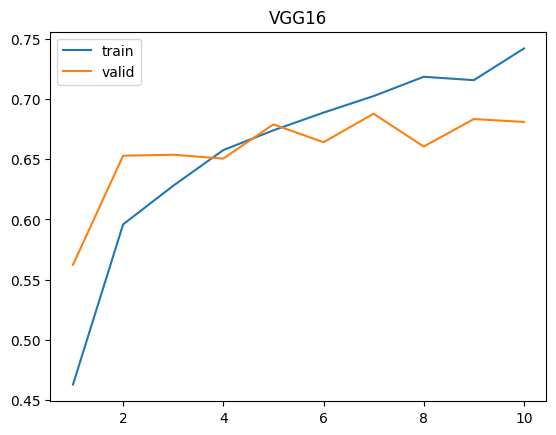

In [ ]:
epoch_count = range(1,11)
plt.title('VGG16')
sns.lineplot(x=epoch_count,  y=history_vgg.history['accuracy'], label='train',)
sns.lineplot(x=epoch_count,  y=history_vgg.history['val_accuracy'], label='valid')
plt.show()

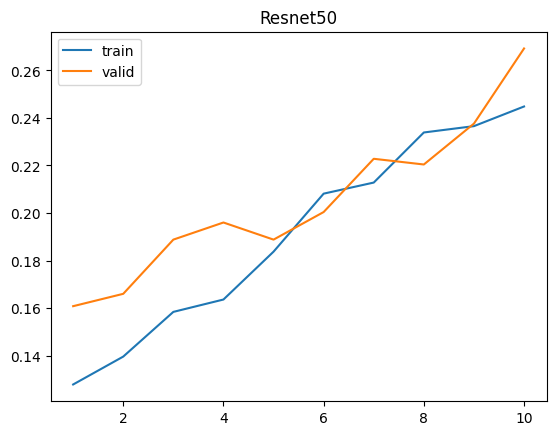

In [ ]:
#realizamos lo mismo con resnet50
plt.title('Resnet50')
sns.lineplot(x=epoch_count,  y=history_resnet50.history['accuracy'], label='train',)
sns.lineplot(x=epoch_count,  y=history_resnet50.history['val_accuracy'], label='valid')
plt.show()

Vemos que vgg16 obtuvo un mejor puntaje y un mejor puntaje de validacion, pero veamos que tal les va realizandoles una prueba.

In [ ]:
#Descargamos la carpeta para realizar el test
if os.access('test_food.zip', os.F_OK) is False:
    if os.access('test_food.zip', os.F_OK) is False:
        url = 'https://drive.google.com/uc?id=1AZjgemd5MIj0SkIwpZLXydK8e3HmWvVO'
        output = '10_food_classes_all_data.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q 10_food_classes_all_data.zip
else:
    print("El archivo ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1AZjgemd5MIj0SkIwpZLXydK8e3HmWvVO
To: /content/10_food_classes_all_data.zip
100%|██████████| 1.27M/1.27M [00:00<00:00, 124MB/s]


In [ ]:
test_dir = "test_food"

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Marcamos la ruta de las imagenes y las normalizamos
test_gen = test_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224),
                                               batch_size=1,
                                               class_mode='categorical',
                                                shuffle = False)

Found 10 images belonging to 10 classes.


Realizamos una evaluacion del modelo

In [ ]:
#Realizamos una evaluación de los modelos
model_vgg.evaluate(test_gen, steps=len(test_gen))

10/10 [==============================] - 0s 22ms/step - loss: 0.3444 - accuracy: 1.0000


[0.34441906213760376, 1.0]

In [ ]:
model_resnet50.evaluate(test_gen, steps=len(test_gen))

10/10 [==============================] - 0s 18ms/step - loss: 2.0665 - accuracy: 0.3000


[2.06654691696167, 0.30000001192092896]

Realizamos una prediccion con los modelos

In [ ]:
y_pred_vgg = model_vgg.predict(test_gen)
y_pred_resnet = model_resnet50.predict(test_gen)

10/10 [==============================] - 1s 16ms/step


In [ ]:
#importamos numpy
import numpy as np


In [ ]:
#Normalizamos los resultados obtenidos
y_pred_vgg = np.where(y_pred_vgg > 0.5, 1, 0)
y_pred_resnet = np.where(y_pred_resnet > 0.5, 1, 0)

In [ ]:
#Obtenemos los resultados
y_pred_vgg = np.argmax(y_pred_vgg, axis=1)
y_pred_resnet = np.argmax(y_pred_resnet, axis=1)

In [ ]:
#obtenemos las clases
y_test = test_gen.classes

In [ ]:
#Importamos la matriz de confusion y la matriz de confusion display
from sklearn.metrics import confusion_matrix, confu

In [ ]:
#creamos la matriz y la matriz display
cm_vgg = confusion_matrix(y_test,y_pred_vgg)
cmd_vgg = ConfusionMatrixDisplay(cm_vgg)
cm_resnet = confusion_matrix(y_test,y_pred_resnet)
cmd_resnet = ConfusionMatrixDisplay(cm_resnet)

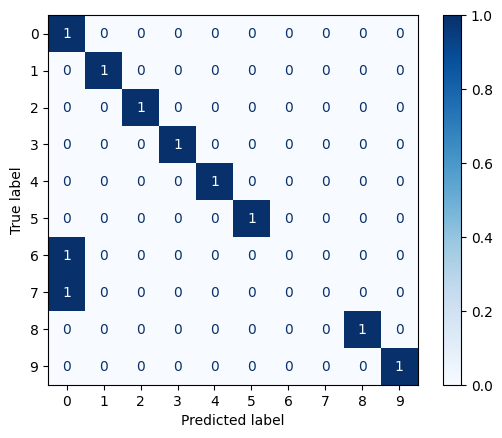

In [ ]:
#Ploteamos las matrices
cmd_vgg.plot(cmap='Blues')
plt.show()

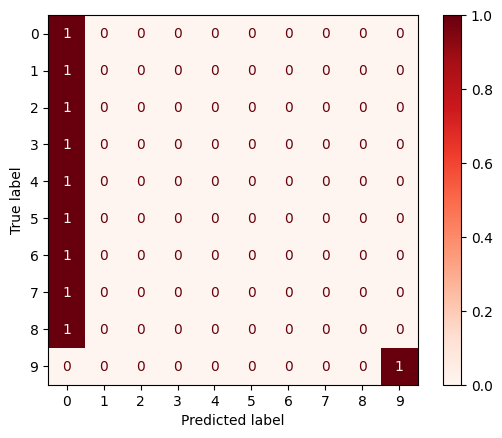

In [ ]:
cmd_resnet.plot(cmap='Reds')
plt.show()

Aqui vemos la diferencia de resultados

Acontinuacion mostrare las imagenes con sus clases, veamos bien en cuales comida se equivocó el modelo.

In [ ]:
#Obtenemos los nombres de las clases
class_names = list(test_gen.class_indices.keys())

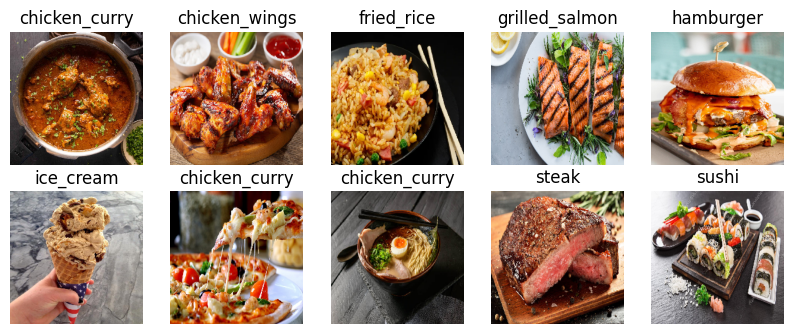

In [ ]:
fig = plt.figure(figsize = (10,10))
for i in range(len(class_names)):
    #obtenemos la imagen
    img = test_gen.next()[0]
    #obtenemos la clase
    clas = y_pred_vgg[i]
    #normalizamos la clase
    clas = class_names[clas]

    #creamos nuestra imagen
    fig.add_subplot(5,5,i+1)
    plt.imshow(img[0])
    plt.title(clas)
    plt.axis('off')
plt.show()

Aqui vemos como VGG clasifico las comidas

Ahora veamos como resnet clasifica las comidas

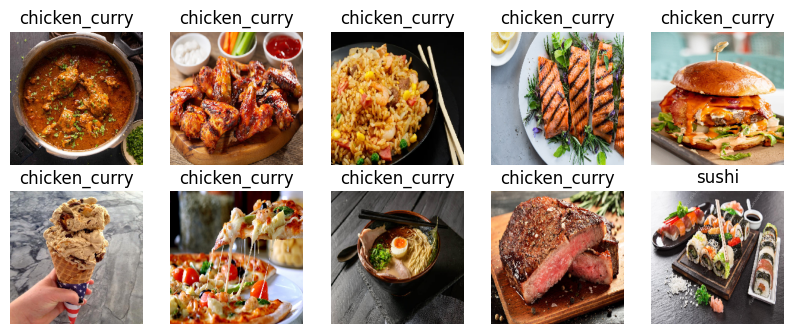

In [ ]:
fig = plt.figure(figsize = (10,10))
for i in range(len(class_names)):
    #obtenemos la imagen
    img = test_gen.next()[0]
    #obtenemos la clase
    clas = y_pred_resnet[i]
    #normalizamos la clase
    clas = class_names[clas]

    #creamos nuestra imagen
    fig.add_subplot(5,5,i+1)
    plt.imshow(img[0])
    plt.title(clas)
    plt.axis('off')
plt.show()

Bien a fines de objetivos el modelo VGG pudo superarlos.